This notebook parses sgf files generated by selfplay (or victimplay).

It presents the files in a searchable and filterable way,
and allows one to easily export files for viewing in Sabaki.

### Load libraries

In [1]:
import dataclasses
import random
from typing import List

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.contrib.concurrent import process_map
import pathlib

from go_attack import game_info

### Load games

In [2]:
DATA_DIR = "../tests/testdata/victimplay-truncated/"
# DATA_DIR = "/nas/ucb/tony/go-attack/training/emcts1-v2/cp127-vis32"
# DATA_DIR = "/nas/ucb/tony/go-attack/training/emcts1-v2/cp127-vis64"
# DATA_DIR = "/nas/ucb/tony/go-attack/training/emcts1-v2/cp127-vis512-try2"

SELFPLAY_DIR = f"{DATA_DIR}/selfplay"
sgf_paths = game_info.find_sgf_files(SELFPLAY_DIR)
parsed_games = game_info.read_and_parse_all_files(sgf_paths)

len(parsed_games)

8

### Parse games

In [3]:
random.seed(42)

In [4]:
%%time
df = pd.DataFrame(parsed_games)
print("gtypes:", df.gtype.unique())
print("Number of cleanup games:", (df.gtype == "cleanuptraining").sum())

# Filter to only normal games
df = df[(df.gtype == "normal")]
print("Fraction continuation:    ", df.is_continuation.mean())
print("Fraction used_initial_pos:", df.used_initial_position.mean())
print("max(init_turn_num)       :", df.init_turn_num.max())

df.head()

gtypes: ['normal']
Number of cleanup games: 0
Fraction continuation:     0.0
Fraction used_initial_pos: 0.0
max(init_turn_num)       : 0
CPU times: user 2.62 ms, sys: 2.11 ms, total: 4.73 ms
Wall time: 4.29 ms


,adv_win,adv_minus_victim_score,board_size,adv_steps,start_turn_idx,komi,adv_komi,handicap,num_moves,ko_rule,...,sgf_line,adv_name,gtype,is_continuation,num_b_pass,num_w_pass,num_adv_pass,num_victim_pass,b_name,w_name
0,True,12.5,19,108263680,0,6.5,-6.5,0,149,POSITIONAL,...,1,t0-s108263680-d27265989,normal,False,"(10,)","(1,)","(10,)","(1,)",t0-s108263680-d27265989__victim,victim
1,True,5.5,19,108263680,0,6.5,-6.5,0,174,POSITIONAL,...,2,t0-s108263680-d27265989,normal,False,"(12,)","(1,)","(12,)","(1,)",t0-s108263680-d27265989__victim,victim
2,True,7.5,19,108263680,0,6.5,6.5,0,131,POSITIONAL,...,3,t0-s108263680-d27265989,normal,False,"(1,)","(16,)","(16,)","(1,)",victim,victim__t0-s108263680-d27265989
3,True,15.5,19,108263680,0,6.5,6.5,0,133,POSITIONAL,...,4,t0-s108263680-d27265989,normal,False,"(1,)","(10,)","(10,)","(1,)",victim,victim__t0-s108263680-d27265989
4,False,-8.5,19,108263680,0,6.5,-6.5,0,243,POSITIONAL,...,5,t0-s108263680-d27265989,normal,False,"(18,)","(1,)","(18,)","(1,)",t0-s108263680-d27265989__victim,victim


In [5]:
df19 = df[df.board_size == 19]
df19.head()

,adv_win,adv_minus_victim_score,board_size,adv_steps,start_turn_idx,komi,adv_komi,handicap,num_moves,ko_rule,...,sgf_line,adv_name,gtype,is_continuation,num_b_pass,num_w_pass,num_adv_pass,num_victim_pass,b_name,w_name
0,True,12.5,19,108263680,0,6.5,-6.5,0,149,POSITIONAL,...,1,t0-s108263680-d27265989,normal,False,"(10,)","(1,)","(10,)","(1,)",t0-s108263680-d27265989__victim,victim
1,True,5.5,19,108263680,0,6.5,-6.5,0,174,POSITIONAL,...,2,t0-s108263680-d27265989,normal,False,"(12,)","(1,)","(12,)","(1,)",t0-s108263680-d27265989__victim,victim
2,True,7.5,19,108263680,0,6.5,6.5,0,131,POSITIONAL,...,3,t0-s108263680-d27265989,normal,False,"(1,)","(16,)","(16,)","(1,)",victim,victim__t0-s108263680-d27265989
3,True,15.5,19,108263680,0,6.5,6.5,0,133,POSITIONAL,...,4,t0-s108263680-d27265989,normal,False,"(1,)","(10,)","(10,)","(1,)",victim,victim__t0-s108263680-d27265989
4,False,-8.5,19,108263680,0,6.5,-6.5,0,243,POSITIONAL,...,5,t0-s108263680-d27265989,normal,False,"(18,)","(1,)","(18,)","(1,)",t0-s108263680-d27265989__victim,victim


### Analyze data

In [6]:
def hist_3d(
    df: pd.DataFrame,
    t_key: str,
    ts: np.ndarray,
    v_key: str,
    ax: plt.Axes,
    cmap: plt.cm.ScalarMappable = plt.cm.inferno,
    bins: int = 50,
):
    """Adapted from https://stackoverflow.com/a/65126279/1337463"""
    ts = np.sort(ts)
    if len(ts) > 2:  # truncate early points which are unreliable
        ts = ts[2:]

    # calculate now the histogram and plot it for each column
    for i, t in enumerate(ts):
        # extract the current column from your df by its number
        col = df[df[t_key] == t][v_key]

        # determine the histogram values, here you have to adapt it to your needs
        histvals, edges = np.histogram(col, bins=bins, density=True)

        # calculate the center and width of each bar
        # obviously not necessary to do this for each column if you always have the same bins
        # but if you choose for np.histogram other parameters, the bins may not be the same for each histogram
        xcenter = np.convolve(edges, np.ones(2), "valid") / 2
        xwidth = np.diff(edges)

        # plot the histogram as a bar for each bin
        # now with continuous color mapping and edgecolor, so we can better see all bars
        ax.bar(
            left=xcenter,
            height=histvals,
            width=xwidth,
            zs=t,
            zdir="y",
            color=cmap(1 - i / len(ts)),
            alpha=0.666,
            edgecolor="grey",
        )

    ax.set_xlabel(v_key)
    ax.set_ylabel(t_key)
    ax.set_zlabel("density")

    ax.set_ylim(ts[-1], ts[0])
    ax.set_yticks(ts[::10])

/var/folders/rb/2wz2xfc56w7dyxqq4j8xnp340000gn/T/ipykernel_75521/2352241916.py:46: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ts[-1], ts[0])


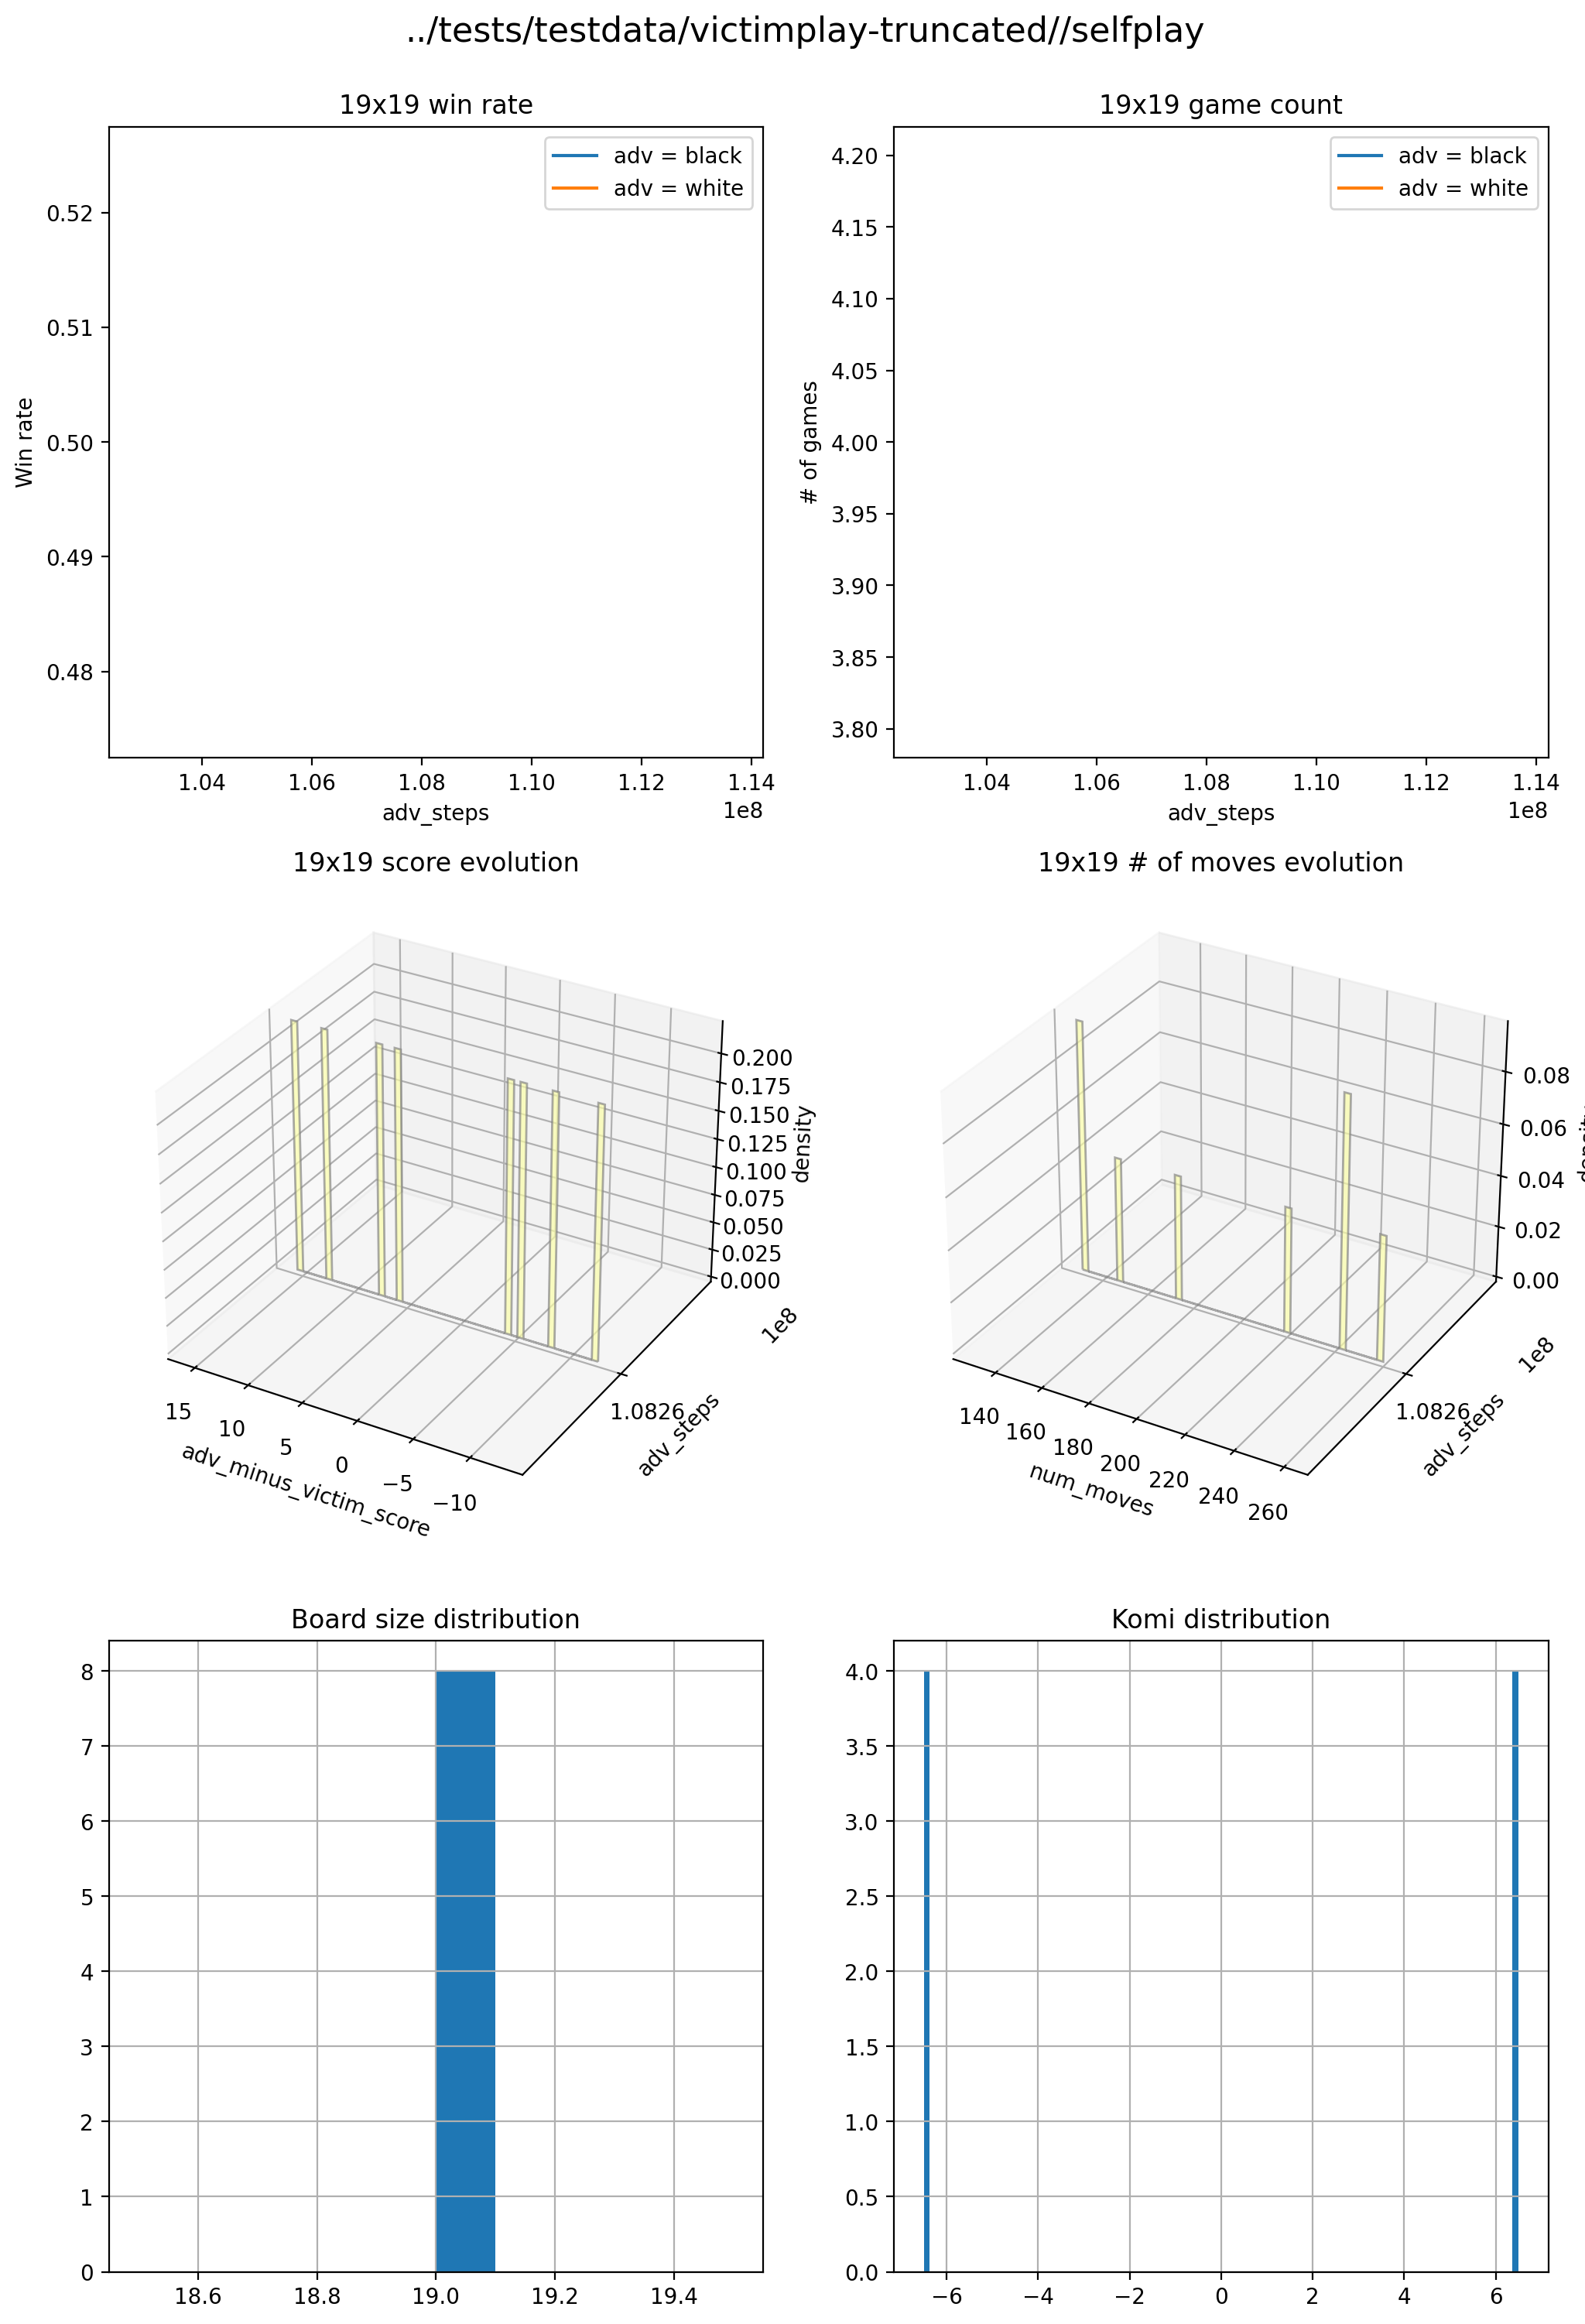

In [7]:
plt.figure(figsize=(12, 18), dpi=200)
plt.suptitle(SELFPLAY_DIR, fontsize=16, y=0.92)

plt.subplot(3, 2, 1)
df19[df19.adv_color == "b"].groupby("adv_steps").mean().adv_win.plot(
    label="adv = black"
)
df19[df19.adv_color == "w"].groupby("adv_steps").mean().adv_win.plot(
    label="adv = white"
)
plt.ylabel("Win rate")
plt.title("19x19 win rate")
plt.legend()

plt.subplot(3, 2, 2)
df19[df19.adv_color == "b"].groupby("adv_steps").count().adv_win.plot(
    label="adv = black"
)
df19[df19.adv_color == "w"].groupby("adv_steps").count().adv_win.plot(
    label="adv = white"
)
plt.ylabel("# of games")
plt.title("19x19 game count")
plt.legend()

ax = plt.subplot(3, 2, 3, projection="3d")
hist_3d(
    df19,
    ts=np.sort(df19.adv_steps.unique()),
    t_key="adv_steps",
    v_key="adv_minus_victim_score",
    ax=ax,
)
ax.invert_xaxis()
plt.title("19x19 score evolution")

ax = plt.subplot(3, 2, 4, projection="3d")
hist_3d(
    df19,
    ts=np.sort(df19.adv_steps.unique()),
    t_key="adv_steps",
    v_key="num_moves",
    ax=ax,
)
plt.title("19x19 # of moves evolution")

plt.subplot(3, 2, 5)
df.board_size.hist()
plt.title("Board size distribution")

plt.subplot(3, 2, 6)
df19.adv_komi.hist(bins=100)
plt.title("Komi distribution");

### Games

In [8]:
def sgf_str_to_url(sgf_str: str) -> str:
    return f"https://humancompatibleai.github.io/sgf-viewer/#sgf={sgf_str}"


@dataclasses.dataclass(frozen=True)
class Url:
    """Wrapper around a URL string to provide nice display in IPython environments."""

    url: str
    text: str

    def _repr_html_(self):
        """HTML link to this URL."""
        return f'<a href="{self.url}">{self.text}</a>'

    def __str__(self):
        """Return the underlying string."""
        return self.url

In [9]:
ADV_STEPS = list(sorted(df19.adv_steps.unique()))
ADV_STEP_VIZ = ADV_STEPS[-5] if len(ADV_STEPS) > 5 else ADV_STEPS[0]
print(ADV_STEP_VIZ)
print(df19)

df_win = df19[(df19.adv_steps == ADV_STEP_VIZ) & df19.adv_win]
print(df_win.adv_color.unique())

df_loss = df19[(df19.adv_steps == ADV_STEP_VIZ) & ~df19.adv_win]
print(df_loss.adv_color.unique())

108263680
   adv_win  adv_minus_victim_score  board_size  adv_steps  start_turn_idx  \
0     True                    12.5          19  108263680               0   
1     True                     5.5          19  108263680               0   
2     True                     7.5          19  108263680               0   
3     True                    15.5          19  108263680               0   
4    False                    -8.5          19  108263680               0   
5    False                    -4.5          19  108263680               0   
6    False                    -5.5          19  108263680               0   
7    False                   -12.5          19  108263680               0   

   komi  adv_komi  handicap  num_moves     ko_rule  ... sgf_line  \
0   6.5      -6.5         0        149  POSITIONAL  ...        1   
1   6.5      -6.5         0        174  POSITIONAL  ...        2   
2   6.5       6.5         0        131  POSITIONAL  ...        3   
3   6.5       6.5       

Text(0.5, 1.0, 'Adv. losses')

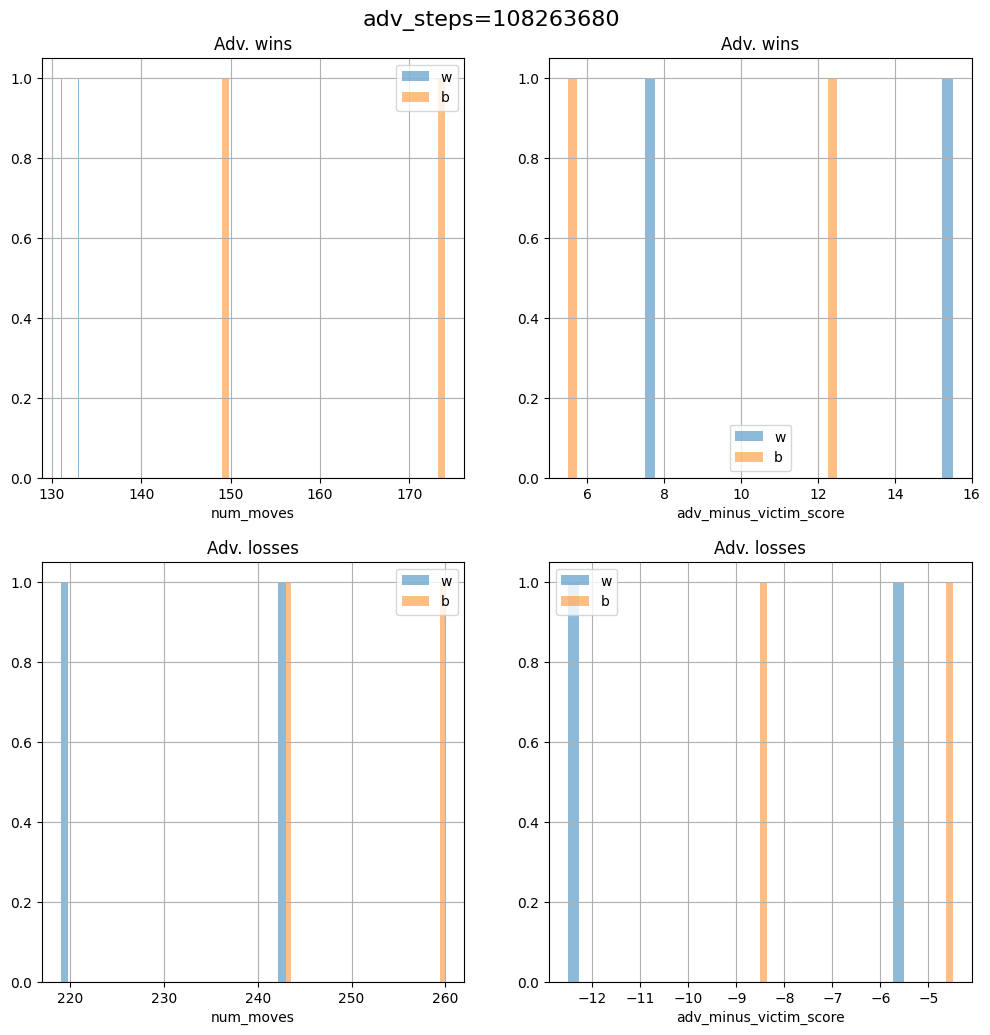

In [10]:
plt.figure(figsize=(12, 12))
plt.suptitle(f"adv_steps={ADV_STEP_VIZ}", fontsize=16, y=0.92)

plt.subplot(2, 2, 1)
df_win[df_win.adv_color == "w"].num_moves.hist(bins=30, label="w", alpha=0.5)
df_win[df_win.adv_color == "b"].num_moves.hist(bins=30, label="b", alpha=0.5)
plt.legend()
plt.xlabel("num_moves")
plt.title("Adv. wins")

plt.subplot(2, 2, 2)
df_win[df_win.adv_color == "w"].adv_minus_victim_score.hist(
    bins=30, label="w", alpha=0.5
)
df_win[df_win.adv_color == "b"].adv_minus_victim_score.hist(
    bins=30, label="b", alpha=0.5
)
plt.legend()
plt.xlabel("adv_minus_victim_score")
plt.title("Adv. wins")

plt.subplot(2, 2, 3)
df_loss[df_loss.adv_color == "w"].num_moves.hist(bins=30, label="w", alpha=0.5)
df_loss[df_loss.adv_color == "b"].num_moves.hist(bins=30, label="b", alpha=0.5)
plt.legend()
plt.xlabel("num_moves")
plt.title("Adv. losses")

plt.subplot(2, 2, 4)
df_loss[df_loss.adv_color == "w"].adv_minus_victim_score.hist(
    bins=30, label="w", alpha=0.5
)
df_loss[df_loss.adv_color == "b"].adv_minus_victim_score.hist(
    bins=30, label="b", alpha=0.5
)
plt.legend()
plt.xlabel("adv_minus_victim_score")
plt.title("Adv. losses")

In [11]:
for df_cur, lab in [(df_win, "win"), (df_loss, "loss")]:
    for color in ["b", "w"]:
        for i in range(2):
            sgf_path = df_cur[df_cur.adv_color == color].sgf_path.iloc[i]
            sgf_line = df_cur[df_cur.adv_color == color].sgf_line.iloc[i]
            sgf_str = game_info.get_game_str(pathlib.Path(sgf_path), sgf_line)
            display(
                Url(
                    url=sgf_str_to_url(sgf_str),
                    text=f"{color}_{lab}{i}={ADV_STEP_VIZ}",
                )
            )

Url(url='https://humancompatibleai.github.io/sgf-viewer/#sgf=(;FF[4]GM[1]SZ[19]PB[t0-s108263680-d27265989__victim]PW[victim]HA[0]KM[6.5]RU[koPOSITIONALscoreAREAtaxNONEsui1]RE[B+12.5]C[startTurnIdx=0,initTurnNum=0,gameHash=B5B369DE905FCC115D2378B92660E883,gtype=normal];B[bb]C[0.39 0.61 0.00 -9.3 v=600 weight=0.75];W[qd]C[0.75 0.25 0.00 6.1 v=32 weight=0.66];B[rr]C[0.36 0.64 0.00 -10.0 v=600 weight=0.80];W[cp]C[0.93 0.07 0.00 13.4 v=32 weight=0.85];B[rb]C[0.36 0.64 0.00 -10.2 v=600 weight=0.89];W[pc]C[0.97 0.03 0.00 17.5 v=32 weight=0.94];B[br]C[0.35 0.65 0.00 -10.3 v=600 weight=1.45];W[dq]C[0.99 0.01 0.00 21.0 v=32 weight=1.00];B[sm]C[0.33 0.67 0.00 -10.5 v=600 weight=1.59];W[op]C[0.99 0.01 0.00 26.4 v=32 weight=1.17];B[dr]C[0.30 0.70 0.00 -10.3 v=600 weight=0.65];W[cr]C[0.99 0.01 0.00 26.5 v=32 weight=0.96];B[es]C[0.29 0.71 0.00 -10.8 v=600 weight=1.14];W[eq]C[1.00 0.00 0.00 32.2 v=32 weight=0.92];B[cs]C[0.27 0.73 0.00 -11.0 v=600 weight=0.96];W[cq]C[1.00 0.00 0.00 32.7 v=32 weight=1.03];B[bp]C[0.25 0.75 0.00 -11.3 v=600 weight=1.05];W[cn]C[1.00 0.00 0.00 36.6 v=32 weight=0.96];B[pb]C[0.23 0.77 0.00 -12.1 v=600 weight=0.65];W[qb]C[1.00 0.00 0.00 38.6 v=32 weight=0.95];B[rd]C[0.22 0.78 0.00 -12.4 v=600 weight=0.78];W[qf]C[1.00 0.00 0.00 41.4 v=32 weight=0.95];B[pd]C[0.21 0.79 0.00 -12.9 v=600 weight=0.90];W[pe]C[1.00 0.00 0.00 46.4 v=32 weight=0.91];B[rp]C[0.20 0.80 0.00 -13.6 v=600 weight=0.69];W[iq]C[1.00 0.00 0.00 47.9 v=32 weight=0.99];B[js]C[0.20 0.80 0.00 -13.7 v=600 weight=0.68];W[lq]C[1.00 0.00 0.00 55.3 v=32 weight=1.14];B[ir]C[0.20 0.80 0.00 -13.9 v=600 weight=0.69];W[jq]C[1.00 0.00 0.00 56.9 v=32 weight=0.93];B[kr]C[0.20 0.80 0.00 -13.9 v=600 weight=0.62];W[kq]C[1.00 0.00 0.00 60.9 v=32 weight=0.81];B[hs]C[0.20 0.80 0.00 -14.3 v=600 weight=0.78];W[hq]C[1.00 0.00 0.00 70.0 v=32 weight=0.90];B[ao]C[0.20 0.80 0.00 -14.3 v=600 weight=0.65];W[cl]C[1.00 0.00 0.00 76.2 v=32 weight=0.85];B[se]C[0.20 0.80 0.00 -14.2 v=600 weight=0.65];W[qq]C[1.00 0.00 0.00 84.9 v=32 weight=1.08];B[rf]C[0.19 0.81 0.00 -14.5 v=600 weight=0.67];W[qg]C[1.00 0.00 0.00 85.6 v=32 weight=0.99];B[mr]C[0.19 0.81 0.00 -14.9 v=600 weight=0.63];W[or]C[1.00 0.00 0.00 85.9 v=32 weight=1.00];B[an]C[0.18 0.82 0.00 -15.0 v=600 weight=0.67];W[bk]C[1.00 0.00 0.00 96.3 v=32 weight=0.95];B[rl]C[0.19 0.81 0.00 -14.2 v=600 weight=0.70];W[ce]C[1.00 0.00 0.00 100.4 v=32 weight=1.08];B[db]C[0.19 0.81 0.00 -14.3 v=600 weight=0.65];W[cc]C[1.00 0.00 0.00 102.2 v=32 weight=0.99];B[ah]C[0.19 0.81 0.00 -14.6 v=600 weight=0.71];W[ec]C[1.00 0.00 0.00 113.1 v=32 weight=1.00];B[ac]C[0.18 0.82 0.00 -14.7 v=600 weight=0.63];W[cb]C[1.00 0.00 0.00 121.4 v=32 weight=1.06];B[bd]C[0.19 0.81 0.00 -14.2 v=600 weight=0.75];W[cd]C[1.00 0.00 0.00 122.6 v=32 weight=0.93];B[bm]C[0.18 0.82 0.00 -14.7 v=600 weight=0.65];W[cm]C[1.00 0.00 0.00 124.3 v=32 weight=0.89];B[gc]C[0.18 0.82 0.00 -15.0 v=600 weight=0.63];W[ic]C[1.00 0.00 0.00 127.6 v=32 weight=1.00];B[gd]C[0.18 0.82 0.00 -14.5 v=600 weight=0.68];W[ie]C[1.00 0.00 0.00 129.6 v=32 weight=0.97];B[ns]C[0.18 0.82 0.00 -14.7 v=600 weight=0.72];W[gf]C[1.00 0.00 0.00 135.6 v=32 weight=0.94];B[ae]C[0.18 0.82 0.00 -14.5 v=600 weight=0.68];W[cg]C[1.00 0.00 0.00 148.0 v=32 weight=1.08];B[ik]C[0.18 0.82 0.00 -14.5 v=600 weight=0.78];W[lj]C[1.00 0.00 0.00 150.5 v=32 weight=0.88];B[oa]C[0.18 0.82 0.00 -14.1 v=600 weight=0.69];W[ii]C[1.00 0.00 0.00 157.1 v=32 weight=0.95];B[ls]C[0.18 0.82 0.00 -13.6 v=600 weight=0.78];W[mq]C[1.00 0.00 0.00 168.0 v=32 weight=1.06];B[al]C[0.18 0.82 0.00 -13.5 v=600 weight=0.78];W[bq]C[1.00 0.00 0.00 176.1 v=32 weight=0.99];B[il]C[0.18 0.82 0.00 -13.7 v=600 weight=0.83];W[kl]C[1.00 0.00 0.00 182.2 v=32 weight=0.90];B[af]C[0.17 0.83 0.00 -13.9 v=600 weight=0.73];W[gi]C[1.00 0.00 0.00 193.8 v=32 weight=0.98];B[aq]C[0.17 0.83 0.00 -13.6 v=600 weight=0.75];W[bi]C[1.00 0.00 0.00 204.3 v=32 weight=0.91];B[bf]C[0.17 0.83 0.00 -13.6 v=600 weight=1.13];W[jr]C[1.00 0.00 0.00 205.5 v=32 weight=0.97];B[qs]C[0.17 0.83 0.00 -14.0 v=600 w

Url(url='https://humancompatibleai.github.io/sgf-viewer/#sgf=(;FF[4]GM[1]SZ[19]PB[t0-s108263680-d27265989__victim]PW[victim]HA[0]KM[6.5]RU[koPOSITIONALscoreAREAtaxNONEsui1]RE[B+5.5]C[startTurnIdx=0,initTurnNum=0,gameHash=1BE4BA0F49A2CAF3B04A33E0731446BE,gtype=normal];B[rb]C[0.39 0.61 0.00 -9.3 v=600 weight=0.74];W[dd]C[0.75 0.25 0.00 6.1 v=32 weight=0.66];B[br]C[0.36 0.64 0.00 -9.9 v=600 weight=0.78];W[pp]C[0.93 0.07 0.00 13.2 v=32 weight=0.81];B[rr]C[0.35 0.65 0.00 -10.1 v=600 weight=0.89];W[qq]C[0.97 0.03 0.00 16.8 v=32 weight=0.80];B[bb]C[0.35 0.65 0.00 -10.3 v=600 weight=0.84];W[kp]C[0.98 0.02 0.00 19.3 v=32 weight=0.98];B[hs]C[0.33 0.67 0.00 -10.2 v=600 weight=1.36];W[em]C[0.99 0.01 0.00 25.2 v=32 weight=0.99];B[rp]C[0.31 0.69 0.00 -10.1 v=600 weight=0.67];W[qn]C[0.99 0.01 0.00 26.1 v=32 weight=0.97];B[sc]C[0.30 0.70 0.00 -10.3 v=600 weight=0.64];W[ep]C[1.00 0.00 0.00 31.4 v=32 weight=0.94];B[dr]C[0.29 0.71 0.00 -10.3 v=600 weight=0.63];W[cc]C[1.00 0.00 0.00 32.1 v=32 weight=1.10];B[af]C[0.28 0.72 0.00 -10.7 v=600 weight=0.63];W[ch]C[1.00 0.00 0.00 37.7 v=32 weight=0.99];B[qs]C[0.27 0.73 0.00 -10.7 v=600 weight=0.67];W[rq]C[1.00 0.00 0.00 43.7 v=32 weight=1.05];B[rn]C[0.25 0.75 0.00 -11.0 v=600 weight=0.62];W[qm]C[1.00 0.00 0.00 46.5 v=32 weight=0.97];B[ak]C[0.24 0.76 0.00 -11.3 v=600 weight=0.64];W[cf]C[1.00 0.00 0.00 54.1 v=32 weight=1.08];B[db]C[0.24 0.76 0.00 -11.2 v=600 weight=0.63];W[gc]C[1.00 0.00 0.00 57.4 v=32 weight=0.93];B[es]C[0.23 0.77 0.00 -11.5 v=600 weight=0.66];W[cq]C[1.00 0.00 0.00 62.7 v=32 weight=0.97];B[ls]C[0.23 0.77 0.00 -11.7 v=600 weight=0.96];W[kr]C[1.00 0.00 0.00 73.2 v=32 weight=1.01];B[pb]C[0.21 0.79 0.00 -12.6 v=600 weight=0.72];W[co]C[1.00 0.00 0.00 74.8 v=32 weight=0.90];B[mr]C[0.21 0.79 0.00 -13.1 v=600 weight=0.65];W[fr]C[1.00 0.00 0.00 79.1 v=32 weight=0.92];B[bd]C[0.20 0.80 0.00 -13.4 v=600 weight=0.59];W[cb]C[1.00 0.00 0.00 83.7 v=32 weight=0.95];B[bp]C[0.20 0.80 0.00 -13.6 v=600 weight=0.59];W[bq]C[1.00 0.00 0.00 84.4 v=32 weight=0.91];B[ek]C[0.19 0.81 0.00 -13.9 v=600 weight=0.59];W[ck]C[1.00 0.00 0.00 85.2 v=32 weight=0.93];B[rl]C[0.19 0.81 0.00 -13.6 v=600 weight=0.58];W[rm]C[1.00 0.00 0.00 87.1 v=32 weight=0.96];B[fb]C[0.19 0.81 0.00 -13.7 v=600 weight=0.62];W[fd]C[1.00 0.00 0.00 90.0 v=32 weight=0.95];B[ia]C[0.19 0.81 0.00 -13.7 v=600 weight=0.59];W[jc]C[1.00 0.00 0.00 96.9 v=32 weight=0.93];B[ca]C[0.19 0.81 0.00 -13.5 v=600 weight=0.67];W[bc]C[1.00 0.00 0.00 99.3 v=32 weight=0.94];B[ej]C[0.19 0.81 0.00 -13.5 v=600 weight=0.62];W[gk]C[1.00 0.00 0.00 104.7 v=32 weight=0.88];B[bg]C[0.19 0.81 0.00 -13.6 v=600 weight=0.61];W[ci]C[1.00 0.00 0.00 109.2 v=32 weight=0.76];B[lc]C[0.19 0.81 0.00 -13.6 v=600 weight=0.58];W[nq]C[1.00 0.00 0.00 108.8 v=32 weight=1.09];B[rj]C[0.19 0.81 0.00 -13.3 v=600 weight=0.59];W[im]C[1.00 0.00 0.00 110.6 v=32 weight=1.00];B[hl]C[0.19 0.81 0.00 -13.4 v=600 weight=0.59];W[ij]C[1.00 0.00 0.00 109.5 v=32 weight=0.95];B[ns]C[0.20 0.80 0.00 -13.0 v=600 weight=0.61];W[ir]C[1.00 0.00 0.00 121.7 v=32 weight=1.03];B[ld]C[0.20 0.80 0.00 -12.8 v=600 weight=0.69];W[jk]C[1.00 0.00 0.00 123.0 v=32 weight=1.00];B[le]C[0.19 0.81 0.00 -12.9 v=600 weight=0.67];W[pk]C[1.00 0.00 0.00 130.8 v=32 weight=1.04];B[ae]C[0.19 0.81 0.00 -12.8 v=600 weight=0.63];W[qi]C[1.00 0.00 0.00 142.0 v=32 weight=0.88];B[ah]C[0.19 0.81 0.00 -12.5 v=600 weight=0.63];W[cg]C[1.00 0.00 0.00 153.6 v=32 weight=0.83];B[ss]C[0.20 0.80 0.00 -12.0 v=600 weight=0.63];W[hb]C[1.00 0.00 0.00 169.5 v=32 weight=0.92];B[rd]C[0.21 0.79 0.00 -11.3 v=600 weight=0.62];W[jg]C[1.00 0.00 0.00 181.1 v=32 weight=0.97];B[rh]C[0.21 0.79 0.00 -11.3 v=600 weight=0.62];W[qh]C[1.00 0.00 0.00 185.1 v=32 weight=0.80];B[so]C[0.21 0.79 0.00 -11.5 v=600 weight=0.69];W[ri]C[1.00 0.00 0.00 194.3 v=32 weight=0.91];B[sm]C[0.21 0.79 0.00 -11.2 v=600 weight=0.64];W[qo]C[1.00 0.00 0.00 201.1 v=32 weight=0.91];B[ao]C[0.22 0.78 0.00 -10.9 v=600 weight=0.69];W[cp]C[1.00 0.00 0.00 212.2 v=32 weight=0.79];B[ac]C[0.21 0.79 0.00 -10.9 v=600 weigh

Url(url='https://humancompatibleai.github.io/sgf-viewer/#sgf=(;FF[4]GM[1]SZ[19]PB[victim]PW[victim__t0-s108263680-d27265989]HA[0]KM[6.5]RU[koPOSITIONALscoreAREAtaxNONEsui1]RE[W+7.5]C[startTurnIdx=0,initTurnNum=0,gameHash=7226C147BC648669ED78EE85A9B3644E,gtype=normal];B[pp]C[0.45 0.55 0.00 -0.5 v=32 weight=0.64];W[lf]C[0.73 0.27 0.00 7.1 v=600 weight=1.07];B[pd]C[0.30 0.70 0.00 -3.7 v=32 weight=0.72];W[dp]C[0.73 0.27 0.00 7.1 v=600 weight=0.80];B[cd]C[0.30 0.70 0.00 -3.5 v=32 weight=0.65];W[ge]C[0.73 0.27 0.00 6.9 v=600 weight=0.68];B[cq]C[0.22 0.78 0.00 -5.7 v=32 weight=0.80];W[le]C[0.73 0.27 0.00 6.9 v=600 weight=0.88];B[dq]C[0.05 0.95 0.00 -12.6 v=32 weight=0.67];W[bb]C[0.71 0.29 0.00 6.1 v=600 weight=0.85];B[dc]C[0.04 0.96 0.00 -15.5 v=32 weight=0.95];W[cf]C[0.72 0.28 0.00 6.4 v=600 weight=0.86];B[fc]C[0.02 0.98 0.00 -15.6 v=32 weight=0.88];W[br]C[0.72 0.28 0.00 6.3 v=600 weight=0.75];B[cp]C[0.01 0.99 0.00 -22.3 v=32 weight=1.03];W[dj]C[0.73 0.27 0.00 6.8 v=600 weight=1.07];B[qn]C[0.01 0.99 0.00 -23.8 v=32 weight=1.07];W[rr]C[0.73 0.27 0.00 6.5 v=600 weight=1.17];B[pr]C[0.00 1.00 0.00 -27.0 v=32 weight=1.11];W[gl]C[0.74 0.26 0.00 7.0 v=600 weight=1.31];B[qf]C[0.00 1.00 0.00 -28.6 v=32 weight=1.11];W[hl]C[0.74 0.26 0.00 6.7 v=600 weight=1.19];B[cm]C[0.00 1.00 0.00 -32.0 v=32 weight=1.08];W[rb]C[0.75 0.25 0.00 6.8 v=600 weight=1.67];B[pb]C[0.00 1.00 0.00 -35.7 v=32 weight=0.99];W[dr]C[0.76 0.24 0.00 7.6 v=600 weight=0.98];B[eq]C[0.00 1.00 0.00 -39.9 v=32 weight=0.94];W[ca]C[0.78 0.22 0.00 8.2 v=600 weight=0.69];B[hd]C[0.00 1.00 0.00 -46.9 v=32 weight=1.02];W[bp]C[0.78 0.22 0.00 8.6 v=600 weight=0.67];B[co]C[0.00 1.00 0.00 -50.0 v=32 weight=0.99];W[qa]C[0.79 0.21 0.00 8.9 v=600 weight=0.66];B[jp]C[0.00 1.00 0.00 -56.4 v=32 weight=1.06];W[bn]C[0.79 0.21 0.00 9.2 v=600 weight=0.64];B[if]C[0.00 1.00 0.00 -59.7 v=32 weight=1.10];W[rp]C[0.80 0.20 0.00 9.8 v=600 weight=0.62];B[ro]C[0.00 1.00 0.00 -59.7 v=32 weight=1.07];W[ao]C[0.79 0.21 0.00 9.7 v=600 weight=0.66];B[ck]C[0.00 1.00 0.00 -68.9 v=32 weight=1.07];W[me]C[0.79 0.21 0.00 9.9 v=600 weight=0.71];B[dk]C[0.00 1.00 0.00 -76.0 v=32 weight=1.08];W[cs]C[0.79 0.21 0.00 9.8 v=600 weight=0.59];B[ej]C[0.00 1.00 0.00 -85.2 v=32 weight=0.98];W[hk]C[0.79 0.21 0.00 9.8 v=600 weight=0.60];B[km]C[0.00 1.00 0.00 -91.9 v=32 weight=1.18];W[qs]C[0.79 0.21 0.00 9.3 v=600 weight=0.58];B[hi]C[0.00 1.00 0.00 -101.2 v=32 weight=1.09];W[gm]C[0.79 0.21 0.00 9.6 v=600 weight=0.57];B[fi]C[0.00 1.00 0.00 -109.3 v=32 weight=1.02];W[sl]C[0.79 0.21 0.00 9.2 v=600 weight=0.60];B[be]C[0.00 1.00 0.00 -119.6 v=32 weight=1.03];W[ld]C[0.79 0.21 0.00 9.2 v=600 weight=0.64];B[nf]C[0.00 1.00 0.00 -126.9 v=32 weight=1.00];W[ke]C[0.79 0.21 0.00 9.1 v=600 weight=0.75];B[jd]C[0.00 1.00 0.00 -136.6 v=32 weight=1.06];W[kf]C[0.80 0.20 0.00 8.9 v=600 weight=0.63];B[ki]C[0.00 1.00 0.00 -151.6 v=32 weight=1.02];W[gk]C[0.80 0.20 0.00 8.8 v=600 weight=0.62];B[im]C[0.00 1.00 0.00 -165.5 v=32 weight=0.97];W[ac]C[0.80 0.20 0.00 8.9 v=600 weight=0.69];B[gq]C[0.00 1.00 0.00 -171.6 v=32 weight=0.97];W[kn]C[0.79 0.21 0.00 8.8 v=600 weight=0.61];B[lm]C[0.00 1.00 0.00 -172.6 v=32 weight=0.95];W[sh]C[0.79 0.21 0.00 8.6 v=600 weight=0.63];B[nh]C[0.00 1.00 0.00 -182.7 v=32 weight=1.03];W[al]C[0.78 0.22 0.00 8.3 v=600 weight=0.66];B[mc]C[0.00 1.00 0.00 -194.6 v=32 weight=1.00];W[am]C[0.78 0.22 0.00 8.3 v=600 weight=0.63];B[bi]C[0.00 1.00 0.00 -206.6 v=32 weight=0.97];W[ea]C[0.78 0.22 0.00 8.1 v=600 weight=0.61];B[bq]C[0.00 1.00 0.00 -215.7 v=32 weight=1.00];W[es]C[0.78 0.22 0.00 8.1 v=600 weight=0.67];B[db]C[0.00 1.00 0.00 -224.6 v=32 weight=1.14];W[sq]C[0.89 0.11 0.00 11.2 v=600 weight=2.37];B[jn]C[0.00 1.00 0.00 -233.4 v=32 weight=1.13];W[fr]C[0.78 0.22 0.00 8.2 v=600 weight=0.63];B[fq]C[0.00 1.00 0.00 -234.1 v=32 weight=0.89];W[gs]C[0.79 0.21 0.00 8.7 v=600 weight=0.63];B[ql]C[0.00 1.00 0.00 -247.0 v=32 weight=1.04];W[eo]C[0.79 0.21 0.00 9.0 v=600 weight=0.79];B[qq]C[0.00 1.00 0.00 -257.7 v=32 weight=1.07];W[fl]C[0.79 0.21 0.00 8.8 v=600

Url(url='https://humancompatibleai.github.io/sgf-viewer/#sgf=(;FF[4]GM[1]SZ[19]PB[victim]PW[victim__t0-s108263680-d27265989]HA[0]KM[6.5]RU[koPOSITIONALscoreAREAtaxNONEsui1]RE[W+15.5]C[startTurnIdx=0,initTurnNum=0,gameHash=1CF97C6AEA6672E648CFD08EC31C8ED2,gtype=normal];B[cp]C[0.45 0.55 0.00 -0.4 v=32 weight=0.72];W[rd]C[0.73 0.27 0.00 7.7 v=600 weight=1.14];B[pp]C[0.30 0.70 0.00 -3.6 v=32 weight=0.69];W[rb]C[0.74 0.26 0.00 7.8 v=600 weight=0.87];B[dc]C[0.07 0.93 0.00 -11.6 v=32 weight=0.81];W[bb]C[0.73 0.27 0.00 7.8 v=600 weight=0.74];B[cd]C[0.03 0.97 0.00 -15.9 v=32 weight=0.86];W[do]C[0.73 0.27 0.00 8.0 v=600 weight=0.77];B[dp]C[0.02 0.98 0.00 -17.5 v=32 weight=0.84];W[bh]C[0.73 0.27 0.00 8.1 v=600 weight=0.76];B[eo]C[0.01 0.99 0.00 -20.1 v=32 weight=1.07];W[ga]C[0.73 0.27 0.00 8.0 v=600 weight=0.74];B[cg]C[0.01 0.99 0.00 -27.2 v=32 weight=1.09];W[rr]C[0.73 0.27 0.00 8.2 v=600 weight=0.83];B[qq]C[0.00 1.00 0.00 -30.7 v=32 weight=1.08];W[br]C[0.73 0.27 0.00 8.4 v=600 weight=0.81];B[jc]C[0.00 1.00 0.00 -34.7 v=32 weight=1.12];W[am]C[0.74 0.26 0.00 8.8 v=600 weight=0.61];B[ck]C[0.00 1.00 0.00 -42.8 v=32 weight=1.11];W[fs]C[0.73 0.27 0.00 8.7 v=600 weight=0.59];B[iq]C[0.00 1.00 0.00 -50.2 v=32 weight=1.13];W[gr]C[0.73 0.27 0.00 8.7 v=600 weight=0.57];B[er]C[0.00 1.00 0.00 -52.9 v=32 weight=0.98];W[sq]C[0.74 0.26 0.00 9.0 v=600 weight=0.58];B[qm]C[0.00 1.00 0.00 -60.5 v=32 weight=1.05];W[pr]C[0.73 0.27 0.00 8.8 v=600 weight=0.67];B[qr]C[0.00 1.00 0.00 -62.8 v=32 weight=0.95];W[rp]C[0.74 0.26 0.00 9.2 v=600 weight=0.61];B[pn]C[0.00 1.00 0.00 -65.8 v=32 weight=0.90];W[sl]C[0.74 0.26 0.00 9.1 v=600 weight=0.65];B[el]C[0.00 1.00 0.00 -73.6 v=32 weight=1.01];W[cs]C[0.74 0.26 0.00 9.1 v=600 weight=0.66];B[dr]C[0.00 1.00 0.00 -80.9 v=32 weight=1.02];W[rm]C[0.74 0.26 0.00 9.0 v=600 weight=0.68];B[rn]C[0.00 1.00 0.00 -82.2 v=32 weight=0.94];W[sn]C[0.74 0.26 0.00 9.1 v=600 weight=0.65];B[rk]C[0.00 1.00 0.00 -88.1 v=32 weight=0.89];W[ro]C[0.75 0.25 0.00 9.4 v=600 weight=0.78];B[qn]C[0.00 1.00 0.00 -90.5 v=32 weight=0.87];W[bl]C[0.77 0.23 0.00 10.1 v=600 weight=0.65];B[kq]C[0.00 1.00 0.00 -95.8 v=32 weight=1.00];W[aq]C[0.76 0.24 0.00 9.8 v=600 weight=0.61];B[bn]C[0.00 1.00 0.00 -102.0 v=32 weight=0.99];W[ea]C[0.76 0.24 0.00 9.8 v=600 weight=0.61];B[gc]C[0.00 1.00 0.00 -110.2 v=32 weight=0.98];W[pl]C[0.76 0.24 0.00 9.9 v=600 weight=0.61];B[ql]C[0.00 1.00 0.00 -112.9 v=32 weight=1.06];W[ja]C[0.76 0.24 0.00 9.8 v=600 weight=0.68];B[jk]C[0.00 1.00 0.00 -122.9 v=32 weight=0.99];W[la]C[0.75 0.25 0.00 9.4 v=600 weight=0.68];B[mc]C[0.00 1.00 0.00 -130.1 v=32 weight=1.07];W[ir]C[0.75 0.25 0.00 9.4 v=600 weight=0.65];B[hq]C[0.00 1.00 0.00 -132.3 v=32 weight=0.95];W[fb]C[0.76 0.24 0.00 10.0 v=600 weight=0.63];B[fc]C[0.00 1.00 0.00 -135.1 v=32 weight=1.06];W[ae]C[0.76 0.24 0.00 10.0 v=600 weight=0.65];B[ch]C[0.00 1.00 0.00 -142.5 v=32 weight=0.97];W[ac]C[0.76 0.24 0.00 10.0 v=600 weight=0.68];B[oi]C[0.00 1.00 0.00 -150.7 v=32 weight=0.95];W[bf]C[0.74 0.26 0.00 9.3 v=600 weight=0.65];B[bg]C[0.00 1.00 0.00 -152.8 v=32 weight=0.89];W[ol]C[0.75 0.25 0.00 9.5 v=600 weight=0.77];B[bd]C[0.00 1.00 0.00 -157.9 v=32 weight=0.97];W[nl]C[0.77 0.23 0.00 10.3 v=600 weight=0.72];B[oj]C[0.00 1.00 0.00 -162.3 v=32 weight=1.00];W[os]C[0.77 0.23 0.00 10.4 v=600 weight=0.70];B[mq]C[0.00 1.00 0.00 -168.4 v=32 weight=0.93];W[nr]C[0.76 0.24 0.00 9.9 v=600 weight=0.71];B[oq]C[0.00 1.00 0.00 -171.5 v=32 weight=0.95];W[bj]C[0.77 0.23 0.00 10.3 v=600 weight=0.65];B[cj]C[0.00 1.00 0.00 -173.6 v=32 weight=1.06];W[kb]C[0.78 0.22 0.00 10.6 v=600 weight=0.72];B[kc]C[0.00 1.00 0.00 -179.3 v=32 weight=0.98];W[ni]C[0.77 0.23 0.00 10.4 v=600 weight=0.73];B[nj]C[0.00 1.00 0.00 -184.8 v=32 weight=0.95];W[ml]C[0.77 0.23 0.00 10.2 v=600 weight=0.72];B[lk]C[0.00 1.00 0.00 -195.3 v=32 weight=0.90];W[ao]C[0.77 0.23 0.00 10.1 v=600 weight=0.80];B[bo]C[0.00 1.00 0.00 -199.1 v=32 weight=0.85];W[ms]C[0.77 0.23 0.00 10.0 v=600 weight=0.68];B[nq]C[0.00 1.00 0.00 -210.0 v=32 weight=0.97];W[mb]C[0.77 0.2

Url(url='https://humancompatibleai.github.io/sgf-viewer/#sgf=(;FF[4]GM[1]SZ[19]PB[t0-s108263680-d27265989__victim]PW[victim]HA[0]KM[6.5]RU[koPOSITIONALscoreAREAtaxNONEsui1]RE[W+8.5]C[startTurnIdx=0,initTurnNum=0,gameHash=935B8690FC2DB68E811FB7B7A4FB0F99,gtype=normal];B[rb]C[0.39 0.61 0.00 -9.3 v=600 weight=0.68];W[pp]C[0.74 0.26 0.00 5.9 v=32 weight=0.67];B[bb]C[0.36 0.64 0.00 -9.9 v=600 weight=0.79];W[cp]C[0.91 0.09 0.00 13.1 v=32 weight=0.76];B[rr]C[0.35 0.65 0.00 -10.2 v=600 weight=0.90];W[dd]C[0.97 0.03 0.00 16.4 v=32 weight=0.83];B[br]C[0.35 0.65 0.00 -10.1 v=600 weight=0.71];W[dq]C[0.98 0.02 0.00 19.7 v=32 weight=0.86];B[am]C[0.33 0.67 0.00 -10.4 v=600 weight=1.45];W[ck]C[0.99 0.01 0.00 25.9 v=32 weight=0.95];B[bl]C[0.31 0.69 0.00 -10.2 v=600 weight=0.59];W[dm]C[0.99 0.01 0.00 27.6 v=32 weight=0.98];B[bj]C[0.31 0.69 0.00 -10.3 v=600 weight=0.72];W[cc]C[1.00 0.00 0.00 29.4 v=32 weight=0.98];B[dr]C[0.30 0.70 0.00 -10.5 v=600 weight=0.60];W[cr]C[1.00 0.00 0.00 29.6 v=32 weight=0.87];B[es]C[0.28 0.72 0.00 -11.2 v=600 weight=1.10];W[fr]C[1.00 0.00 0.00 33.9 v=32 weight=0.87];B[qa]C[0.25 0.75 0.00 -12.1 v=600 weight=0.65];W[qq]C[1.00 0.00 0.00 41.2 v=32 weight=0.90];B[bd]C[0.25 0.75 0.00 -12.2 v=600 weight=0.63];W[cg]C[1.00 0.00 0.00 43.4 v=32 weight=0.98];B[bp]C[0.24 0.76 0.00 -12.5 v=600 weight=0.61];W[bq]C[1.00 0.00 0.00 44.8 v=32 weight=0.82];B[cs]C[0.23 0.77 0.00 -12.9 v=600 weight=1.03];W[cq]C[1.00 0.00 0.00 45.8 v=32 weight=0.77];B[bn]C[0.21 0.79 0.00 -13.3 v=600 weight=0.69];W[co]C[1.00 0.00 0.00 48.2 v=32 weight=0.85];B[pr]C[0.21 0.79 0.00 -13.5 v=600 weight=0.56];W[mq]C[1.00 0.00 0.00 50.7 v=32 weight=0.87];B[ao]C[0.21 0.79 0.00 -13.7 v=600 weight=0.62];W[bk]C[1.00 0.00 0.00 60.5 v=32 weight=0.90];B[db]C[0.20 0.80 0.00 -14.2 v=600 weight=0.59];W[cj]C[1.00 0.00 0.00 63.8 v=32 weight=0.92];B[js]C[0.19 0.81 0.00 -14.5 v=600 weight=0.57];W[jq]C[1.00 0.00 0.00 70.7 v=32 weight=0.95];B[nr]C[0.19 0.81 0.00 -14.5 v=600 weight=0.74];W[oq]C[1.00 0.00 0.00 71.7 v=32 weight=0.85];B[sj]C[0.19 0.81 0.00 -14.6 v=600 weight=0.56];W[lm]C[1.00 0.00 0.00 79.9 v=32 weight=1.08];B[ri]C[0.19 0.81 0.00 -14.3 v=600 weight=0.60];W[or]C[1.00 0.00 0.00 82.1 v=32 weight=1.03];B[rg]C[0.19 0.81 0.00 -14.3 v=600 weight=0.60];W[il]C[1.00 0.00 0.00 83.4 v=32 weight=0.94];B[ai]C[0.19 0.81 0.00 -14.4 v=600 weight=0.67];W[bc]C[1.00 0.00 0.00 91.7 v=32 weight=0.95];B[nm]C[0.19 0.81 0.00 -14.3 v=600 weight=0.62];W[gc]C[1.00 0.00 0.00 95.6 v=32 weight=0.86];B[bh]C[0.19 0.81 0.00 -14.0 v=600 weight=0.58];W[ci]C[1.00 0.00 0.00 96.9 v=32 weight=0.83];B[rk]C[0.19 0.81 0.00 -14.0 v=600 weight=0.65];W[df]C[1.00 0.00 0.00 103.7 v=32 weight=0.95];B[om]C[0.20 0.80 0.00 -13.8 v=600 weight=0.59];W[jh]C[1.00 0.00 0.00 109.2 v=32 weight=0.94];B[pb]C[0.20 0.80 0.00 -13.6 v=600 weight=0.59];W[jc]C[1.00 0.00 0.00 116.6 v=32 weight=0.84];B[kr]C[0.19 0.81 0.00 -13.7 v=600 weight=0.62];W[kq]C[1.00 0.00 0.00 123.6 v=32 weight=0.77];B[ae]C[0.20 0.80 0.00 -13.7 v=600 weight=0.64];W[ke]C[1.00 0.00 0.00 130.2 v=32 weight=0.91];B[sd]C[0.20 0.80 0.00 -13.5 v=600 weight=0.59];W[lk]C[1.00 0.00 0.00 143.6 v=32 weight=0.85];B[so]C[0.21 0.79 0.00 -12.9 v=600 weight=0.64];W[rn]C[1.00 0.00 0.00 155.9 v=32 weight=0.92];B[rp]C[0.21 0.79 0.00 -13.2 v=600 weight=0.68];W[rq]C[1.00 0.00 0.00 155.9 v=32 weight=0.82];B[mi]C[0.21 0.79 0.00 -13.2 v=600 weight=0.59];W[lh]C[1.00 0.00 0.00 154.6 v=32 weight=0.86];B[hs]C[0.21 0.79 0.00 -12.8 v=600 weight=0.70];W[gr]C[1.00 0.00 0.00 164.0 v=32 weight=0.86];B[ms]C[0.20 0.80 0.00 -13.2 v=600 weight=0.59];W[qo]C[1.00 0.00 0.00 172.5 v=32 weight=0.79];B[ag]C[0.20 0.80 0.00 -13.4 v=600 weight=0.61];W[cb]C[1.00 0.00 0.00 179.7 v=32 weight=0.84];B[sl]C[0.20 0.80 0.00 -13.1 v=600 weight=0.60];W[rm]C[1.00 0.00 0.00 187.5 v=32 weight=0.82];B[ha]C[0.21 0.79 0.00 -12.8 v=600 weight=0.65];W[nk]C[1.00 0.00 0.00 194.5 v=32 weight=0.85];B[ak]C[0.20 0.80 0.00 -12.5 v=600 weight=0.61];W[cm]C[1.00 0.00 0.00 195.7 v=32 weight=0.88];B[on]C[0.21 0.79 0.00 -12.4 v=600 weight

Url(url='https://humancompatibleai.github.io/sgf-viewer/#sgf=(;FF[4]GM[1]SZ[19]PB[t0-s108263680-d27265989__victim]PW[victim]HA[0]KM[6.5]RU[koPOSITIONALscoreAREAtaxNONEsui1]RE[W+4.5]C[startTurnIdx=0,initTurnNum=0,gameHash=50341EF8D6A0FC2789001D10F5BE6037,gtype=normal];B[rb]C[0.39 0.61 0.00 -9.3 v=600 weight=0.73];W[cd]C[0.76 0.24 0.00 6.3 v=32 weight=0.61];B[rr]C[0.36 0.64 0.00 -10.1 v=600 weight=0.74];W[cp]C[0.92 0.08 0.00 13.0 v=32 weight=0.67];B[br]C[0.36 0.64 0.00 -10.3 v=600 weight=0.74];W[dq]C[0.97 0.03 0.00 17.6 v=32 weight=0.78];B[sg]C[0.35 0.65 0.00 -10.1 v=600 weight=1.23];W[oq]C[0.99 0.01 0.00 23.6 v=32 weight=0.91];B[bb]C[0.32 0.68 0.00 -10.0 v=600 weight=0.71];W[dc]C[0.99 0.01 0.00 26.0 v=32 weight=0.93];B[pr]C[0.30 0.70 0.00 -10.3 v=600 weight=0.61];W[po]C[0.99 0.01 0.00 27.9 v=32 weight=0.93];B[db]C[0.30 0.70 0.00 -10.5 v=600 weight=0.61];W[ec]C[1.00 0.00 0.00 28.9 v=32 weight=0.86];B[pb]C[0.28 0.72 0.00 -11.0 v=600 weight=0.66];W[or]C[1.00 0.00 0.00 28.9 v=32 weight=0.97];B[rd]C[0.27 0.73 0.00 -11.5 v=600 weight=0.59];W[rp]C[1.00 0.00 0.00 32.5 v=32 weight=1.01];B[sp]C[0.27 0.73 0.00 -11.6 v=600 weight=0.64];W[ro]C[1.00 0.00 0.00 37.3 v=32 weight=0.91];B[fb]C[0.26 0.74 0.00 -12.0 v=600 weight=0.63];W[eb]C[1.00 0.00 0.00 39.0 v=32 weight=0.93];B[ga]C[0.25 0.75 0.00 -12.2 v=600 weight=0.62];W[ic]C[1.00 0.00 0.00 46.1 v=32 weight=0.96];B[sk]C[0.24 0.76 0.00 -12.1 v=600 weight=0.60];W[hd]C[1.00 0.00 0.00 51.7 v=32 weight=0.94];B[ac]C[0.24 0.76 0.00 -11.9 v=600 weight=0.60];W[bd]C[1.00 0.00 0.00 58.6 v=32 weight=0.88];B[nr]C[0.24 0.76 0.00 -12.1 v=600 weight=0.59];W[mq]C[1.00 0.00 0.00 61.2 v=32 weight=0.85];B[fl]C[0.24 0.76 0.00 -12.3 v=600 weight=0.60];W[dj]C[1.00 0.00 0.00 61.8 v=32 weight=0.99];B[ao]C[0.24 0.76 0.00 -11.7 v=600 weight=0.65];W[cm]C[1.00 0.00 0.00 69.8 v=32 weight=0.84];B[bn]C[0.24 0.76 0.00 -11.9 v=600 weight=0.61];W[cn]C[1.00 0.00 0.00 72.5 v=32 weight=0.87];B[gl]C[0.24 0.76 0.00 -12.0 v=600 weight=0.60];W[gi]C[1.00 0.00 0.00 75.4 v=32 weight=1.03];B[sn]C[0.22 0.78 0.00 -12.3 v=600 weight=0.72];W[ho]C[1.00 0.00 0.00 83.3 v=32 weight=0.93];B[hb]C[0.21 0.79 0.00 -13.0 v=600 weight=0.61];W[kc]C[1.00 0.00 0.00 85.7 v=32 weight=0.84];B[ea]C[0.21 0.79 0.00 -13.0 v=600 weight=0.62];W[gc]C[1.00 0.00 0.00 89.5 v=32 weight=0.90];B[am]C[0.21 0.79 0.00 -13.1 v=600 weight=0.58];W[ck]C[1.00 0.00 0.00 101.4 v=32 weight=1.05];B[bl]C[0.21 0.79 0.00 -12.7 v=600 weight=0.59];W[il]C[1.00 0.00 0.00 104.8 v=32 weight=0.86];B[fd]C[0.21 0.79 0.00 -12.9 v=600 weight=0.80];W[fc]C[1.00 0.00 0.00 110.6 v=32 weight=0.74];B[is]C[0.20 0.80 0.00 -13.3 v=600 weight=0.63];W[ij]C[1.00 0.00 0.00 120.7 v=32 weight=0.89];B[gs]C[0.20 0.80 0.00 -13.0 v=600 weight=0.63];W[er]C[1.00 0.00 0.00 128.3 v=32 weight=0.81];B[jb]C[0.21 0.79 0.00 -12.7 v=600 weight=0.58];W[kq]C[1.00 0.00 0.00 128.2 v=32 weight=0.86];B[bj]C[0.21 0.79 0.00 -12.8 v=600 weight=0.67];W[bk]C[1.00 0.00 0.00 129.8 v=32 weight=0.84];B[ee]C[0.20 0.80 0.00 -13.1 v=600 weight=0.62];W[cg]C[1.00 0.00 0.00 136.2 v=32 weight=0.89];B[fe]C[0.20 0.80 0.00 -12.8 v=600 weight=0.64];W[bp]C[1.00 0.00 0.00 146.1 v=32 weight=0.86];B[kk]C[0.20 0.80 0.00 -12.9 v=600 weight=0.67];W[jm]C[1.00 0.00 0.00 146.4 v=32 weight=0.91];B[jr]C[0.20 0.80 0.00 -12.4 v=600 weight=0.62];W[hr]C[1.00 0.00 0.00 147.3 v=32 weight=0.81];B[kl]C[0.19 0.81 0.00 -12.9 v=600 weight=0.63];W[ki]C[1.00 0.00 0.00 152.7 v=32 weight=0.93];B[rf]C[0.19 0.81 0.00 -13.1 v=600 weight=0.62];W[ib]C[1.00 0.00 0.00 159.0 v=32 weight=0.87];B[lr]C[0.20 0.80 0.00 -12.9 v=600 weight=0.67];W[lq]C[1.00 0.00 0.00 161.2 v=32 weight=0.80];B[lk]C[0.20 0.80 0.00 -12.7 v=600 weight=0.60];W[mi]C[1.00 0.00 0.00 168.9 v=32 weight=0.98];B[aq]C[0.19 0.81 0.00 -12.6 v=600 weight=0.65];W[nk]C[1.00 0.00 0.00 183.2 v=32 weight=0.93];B[ia]C[0.19 0.81 0.00 -12.6 v=600 weight=0.68];W[jc]C[1.00 0.00 0.00 192.7 v=32 weight=0.85];B[ai]C[0.19 0.81 0.00 -12.5 v=600 weight=0.68];W[pk]C[1.00 0.00 0.00 203.1 v=32 weight=0.89];B[bh]C[0.19 0.81 0.00 -12.4 v=600 we

Url(url='https://humancompatibleai.github.io/sgf-viewer/#sgf=(;FF[4]GM[1]SZ[19]PB[victim]PW[victim__t0-s108263680-d27265989]HA[0]KM[6.5]RU[koPOSITIONALscoreAREAtaxNONEsui1]RE[B+5.5]C[startTurnIdx=0,initTurnNum=0,gameHash=C4F2EF9F4E99838880A4060F661E7074,gtype=normal];B[dp]C[0.46 0.54 0.00 -0.2 v=32 weight=0.62];W[bi]C[0.73 0.27 0.00 7.7 v=600 weight=0.83];B[cd]C[0.22 0.78 0.00 -5.8 v=32 weight=0.62];W[jj]C[0.73 0.27 0.00 7.7 v=600 weight=0.71];B[pd]C[0.15 0.85 0.00 -7.8 v=32 weight=0.59];W[mr]C[0.73 0.27 0.00 7.2 v=600 weight=0.65];B[qp]C[0.06 0.94 0.00 -12.1 v=32 weight=0.63];W[ne]C[0.73 0.27 0.00 7.1 v=600 weight=0.67];B[nc]C[0.04 0.96 0.00 -13.6 v=32 weight=0.75];W[bb]C[0.73 0.27 0.00 6.9 v=600 weight=0.65];B[ec]C[0.02 0.98 0.00 -17.2 v=32 weight=0.75];W[rb]C[0.73 0.27 0.00 7.1 v=600 weight=0.57];B[qc]C[0.01 0.99 0.00 -19.5 v=32 weight=0.81];W[fp]C[0.73 0.27 0.00 7.3 v=600 weight=0.59];B[dn]C[0.01 0.99 0.00 -20.5 v=32 weight=0.84];W[ci]C[0.73 0.27 0.00 7.0 v=600 weight=0.56];B[qf]C[0.01 0.99 0.00 -24.1 v=32 weight=0.86];W[hl]C[0.72 0.28 0.00 6.5 v=600 weight=0.57];B[cl]C[0.00 1.00 0.00 -25.5 v=32 weight=0.91];W[br]C[0.72 0.28 0.00 6.1 v=600 weight=0.57];B[cq]C[0.00 1.00 0.00 -28.9 v=32 weight=0.83];W[rr]C[0.71 0.29 0.00 6.2 v=600 weight=0.56];B[pq]C[0.00 1.00 0.00 -32.6 v=32 weight=0.94];W[bp]C[0.72 0.28 0.00 6.8 v=600 weight=0.70];B[bq]C[0.00 1.00 0.00 -33.3 v=32 weight=0.94];W[cs]C[0.73 0.27 0.00 7.2 v=600 weight=0.82];B[kr]C[0.00 1.00 0.00 -43.0 v=32 weight=0.82];W[gd]C[0.75 0.25 0.00 8.0 v=600 weight=0.53];B[hq]C[0.00 1.00 0.00 -41.4 v=32 weight=0.90];W[hm]C[0.75 0.25 0.00 7.9 v=600 weight=0.55];B[go]C[0.00 1.00 0.00 -46.3 v=32 weight=0.86];W[db]C[0.76 0.24 0.00 7.9 v=600 weight=0.57];B[fe]C[0.00 1.00 0.00 -47.7 v=32 weight=0.82];W[nf]C[0.76 0.24 0.00 8.3 v=600 weight=0.54];B[eb]C[0.00 1.00 0.00 -53.5 v=32 weight=0.86];W[gc]C[0.77 0.23 0.00 8.3 v=600 weight=0.60];B[cf]C[0.00 1.00 0.00 -56.8 v=32 weight=0.82];W[fq]C[0.77 0.23 0.00 8.2 v=600 weight=0.57];B[fo]C[0.00 1.00 0.00 -61.2 v=32 weight=0.81];W[hd]C[0.77 0.23 0.00 8.1 v=600 weight=0.53];B[kc]C[0.00 1.00 0.00 -68.6 v=32 weight=0.94];W[fs]C[0.77 0.23 0.00 7.8 v=600 weight=0.75];B[gr]C[0.00 1.00 0.00 -77.2 v=32 weight=0.85];W[os]C[0.78 0.22 0.00 8.2 v=600 weight=0.53];B[ke]C[0.00 1.00 0.00 -83.3 v=32 weight=0.86];W[kp]C[0.77 0.23 0.00 8.2 v=600 weight=0.54];B[hf]C[0.00 1.00 0.00 -84.6 v=32 weight=0.89];W[kk]C[0.78 0.22 0.00 8.1 v=600 weight=0.55];B[jg]C[0.00 1.00 0.00 -86.4 v=32 weight=0.97];W[ao]C[0.77 0.23 0.00 7.6 v=600 weight=0.63];B[lk]C[0.00 1.00 0.00 -95.1 v=32 weight=0.86];W[jk]C[0.77 0.23 0.00 8.0 v=600 weight=0.54];B[lj]C[0.00 1.00 0.00 -102.3 v=32 weight=0.91];W[on]C[0.77 0.23 0.00 7.5 v=600 weight=0.55];B[mq]C[0.00 1.00 0.00 -102.8 v=32 weight=0.80];W[ea]C[0.78 0.22 0.00 7.7 v=600 weight=0.65];B[dc]C[0.00 1.00 0.00 -103.4 v=32 weight=0.73];W[ih]C[0.78 0.22 0.00 7.8 v=600 weight=0.57];B[nq]C[0.00 1.00 0.00 -106.6 v=32 weight=0.86];W[pr]C[0.78 0.22 0.00 7.4 v=600 weight=0.61];B[lm]C[0.00 1.00 0.00 -108.4 v=32 weight=0.83];W[ca]C[0.78 0.22 0.00 7.5 v=600 weight=0.61];B[fb]C[0.00 1.00 0.00 -112.7 v=32 weight=0.76];W[sc]C[0.78 0.22 0.00 8.0 v=600 weight=0.55];B[pj]C[0.00 1.00 0.00 -123.6 v=32 weight=0.80];W[ja]C[0.78 0.22 0.00 8.1 v=600 weight=0.56];B[rq]C[0.00 1.00 0.00 -131.6 v=32 weight=0.77];W[me]C[0.78 0.22 0.00 8.0 v=600 weight=0.55];B[lh]C[0.00 1.00 0.00 -139.6 v=32 weight=0.87];W[ae]C[0.79 0.21 0.00 7.7 v=600 weight=0.66];B[in]C[0.00 1.00 0.00 -149.4 v=32 weight=0.87];W[er]C[0.79 0.21 0.00 8.0 v=600 weight=0.59];B[gi]C[0.00 1.00 0.00 -156.3 v=32 weight=0.85];W[dr]C[0.79 0.21 0.00 8.1 v=600 weight=0.57];B[gk]C[0.00 1.00 0.00 -165.8 v=32 weight=0.77];W[al]C[0.80 0.20 0.00 8.1 v=600 weight=0.56];B[jm]C[0.00 1.00 0.00 -174.2 v=32 weight=0.84];W[ij]C[0.80 0.20 0.00 8.2 v=600 weight=0.58];B[bk]C[0.00 1.00 0.00 -185.2 v=32 weight=0.84];W[bh]C[0.80 0.20 0.00 7.6 v=600 weight=0.58];B[ei]C[0.00 1.00 0.00 -196.8 v=32 weight=0.82];W[sn]C[0.79 0.21 0.00 7.2 v=600 we

Url(url='https://humancompatibleai.github.io/sgf-viewer/#sgf=(;FF[4]GM[1]SZ[19]PB[victim]PW[victim__t0-s108263680-d27265989]HA[0]KM[6.5]RU[koPOSITIONALscoreAREAtaxNONEsui1]RE[B+12.5]C[startTurnIdx=0,initTurnNum=0,gameHash=F98E42BB24990E164467B0FFF5647B07,gtype=normal];B[cd]C[0.44 0.56 0.00 -0.6 v=32 weight=0.60];W[ja]C[0.73 0.27 0.00 7.7 v=600 weight=1.04];B[dp]C[0.07 0.93 0.00 -11.7 v=32 weight=0.65];W[bb]C[0.73 0.27 0.00 7.7 v=600 weight=0.98];B[dc]C[0.03 0.97 0.00 -16.0 v=32 weight=0.81];W[rb]C[0.74 0.26 0.00 8.3 v=600 weight=0.83];B[pp]C[0.01 0.99 0.00 -20.5 v=32 weight=0.88];W[rr]C[0.74 0.26 0.00 8.4 v=600 weight=0.75];B[od]C[0.01 0.99 0.00 -23.3 v=32 weight=0.94];W[dr]C[0.74 0.26 0.00 8.6 v=600 weight=0.67];B[qc]C[0.01 0.99 0.00 -25.8 v=32 weight=0.95];W[br]C[0.74 0.26 0.00 8.6 v=600 weight=0.67];B[qq]C[0.00 1.00 0.00 -29.9 v=32 weight=0.95];W[ca]C[0.74 0.26 0.00 8.9 v=600 weight=0.59];B[fc]C[0.00 1.00 0.00 -37.0 v=32 weight=0.96];W[ag]C[0.74 0.26 0.00 8.8 v=600 weight=0.56];B[cq]C[0.00 1.00 0.00 -44.5 v=32 weight=0.93];W[gj]C[0.74 0.26 0.00 8.8 v=600 weight=0.62];B[fq]C[0.00 1.00 0.00 -45.3 v=32 weight=0.96];W[ai]C[0.73 0.27 0.00 8.5 v=600 weight=0.59];B[pm]C[0.00 1.00 0.00 -51.9 v=32 weight=1.00];W[sk]C[0.72 0.28 0.00 8.1 v=600 weight=0.55];B[bh]C[0.00 1.00 0.00 -59.9 v=32 weight=0.95];W[qo]C[0.73 0.27 0.00 8.3 v=600 weight=0.60];B[po]C[0.00 1.00 0.00 -58.3 v=32 weight=0.95];W[jj]C[0.72 0.28 0.00 8.1 v=600 weight=0.53];B[qn]C[0.00 1.00 0.00 -59.8 v=32 weight=0.94];W[ia]C[0.72 0.28 0.00 7.9 v=600 weight=0.59];B[jl]C[0.00 1.00 0.00 -68.3 v=32 weight=0.97];W[os]C[0.73 0.27 0.00 8.2 v=600 weight=0.59];B[lq]C[0.00 1.00 0.00 -76.1 v=32 weight=0.89];W[pr]C[0.73 0.27 0.00 8.3 v=600 weight=0.56];B[nr]C[0.00 1.00 0.00 -79.3 v=32 weight=0.99];W[fj]C[0.74 0.26 0.00 8.8 v=600 weight=0.57];B[qh]C[0.00 1.00 0.00 -81.8 v=32 weight=0.96];W[jb]C[0.75 0.25 0.00 9.1 v=600 weight=0.56];B[kj]C[0.00 1.00 0.00 -89.3 v=32 weight=0.95];W[fr]C[0.74 0.26 0.00 8.6 v=600 weight=0.58];B[gq]C[0.00 1.00 0.00 -90.0 v=32 weight=0.84];W[hr]C[0.75 0.25 0.00 8.9 v=600 weight=0.61];B[gr]C[0.00 1.00 0.00 -94.6 v=32 weight=0.85];W[gs]C[0.75 0.25 0.00 9.2 v=600 weight=0.59];B[er]C[0.00 1.00 0.00 -97.4 v=32 weight=0.81];W[ae]C[0.74 0.26 0.00 9.0 v=600 weight=0.62];B[ji]C[0.00 1.00 0.00 -103.5 v=32 weight=0.88];W[rd]C[0.74 0.26 0.00 8.6 v=600 weight=0.65];B[ij]C[0.00 1.00 0.00 -107.2 v=32 weight=0.89];W[es]C[0.74 0.26 0.00 8.8 v=600 weight=0.66];B[eq]C[0.00 1.00 0.00 -111.2 v=32 weight=0.73];W[li]C[0.75 0.25 0.00 9.1 v=600 weight=0.66];B[cj]C[0.00 1.00 0.00 -112.7 v=32 weight=0.87];W[db]C[0.76 0.24 0.00 9.7 v=600 weight=0.61];B[dl]C[0.00 1.00 0.00 -114.7 v=32 weight=0.97];W[bf]C[0.76 0.24 0.00 9.9 v=600 weight=0.71];B[dg]C[0.00 1.00 0.00 -117.6 v=32 weight=0.92];W[fk]C[0.75 0.25 0.00 9.6 v=600 weight=0.62];B[gh]C[0.00 1.00 0.00 -124.3 v=32 weight=0.93];W[hp]C[0.76 0.24 0.00 9.8 v=600 weight=0.63];B[hq]C[0.00 1.00 0.00 -126.0 v=32 weight=0.83];W[ho]C[0.76 0.24 0.00 10.1 v=600 weight=0.64];B[gl]C[0.00 1.00 0.00 -131.4 v=32 weight=0.87];W[bd]C[0.77 0.23 0.00 9.9 v=600 weight=0.56];B[iq]C[0.00 1.00 0.00 -135.5 v=32 weight=0.89];W[ea]C[0.77 0.23 0.00 10.1 v=600 weight=0.63];B[oh]C[0.00 1.00 0.00 -144.1 v=32 weight=0.89];W[ao]C[0.76 0.24 0.00 9.7 v=600 weight=0.56];B[bl]C[0.00 1.00 0.00 -152.8 v=32 weight=0.82];W[go]C[0.76 0.24 0.00 9.7 v=600 weight=0.60];B[je]C[0.00 1.00 0.00 -162.2 v=32 weight=0.97];W[is]C[0.77 0.23 0.00 9.7 v=600 weight=0.58];B[ld]C[0.00 1.00 0.00 -174.9 v=32 weight=0.85];W[qf]C[0.77 0.23 0.00 9.7 v=600 weight=0.60];B[rc]C[0.00 1.00 0.00 -178.6 v=32 weight=0.79];W[lj]C[0.77 0.23 0.00 9.6 v=600 weight=0.61];B[ni]C[0.00 1.00 0.00 -176.8 v=32 weight=0.81];W[gn]C[0.78 0.22 0.00 9.8 v=600 weight=0.63];B[fl]C[0.00 1.00 0.00 -185.9 v=32 weight=0.79];W[bi]C[0.78 0.22 0.00 9.4 v=600 weight=0.64];B[ci]C[0.00 1.00 0.00 -191.1 v=32 weight=0.83];W[sf]C[0.77 0.23 0.00 9.2 v=600 weight=0.65];B[qd]C[0.00 1.00 0.00 -201.3 v=32 weight=0.76];W[aj]C[0.77 0.23 0.00 9.0